# <center> Kinetic Parameter Estimation </center>

<center>
    <b> Vibhav Dabadghao </b>
    <br>
    <i> April 22, 2020 <i/>
</center>

<div style="text-align: center;">
    <div style="display: inline-block; text-align: left;">
        <ul>
            <li> We are given a <b> reaction mixture containing three species </b> , and
                 the associated reaction mechanism. </li>
          <li> The data we consider are absorbance measurements and come from <b> spectroscopic experiments. </b> </li>
            <li> We want to estimate the <b> kinetic parameters </b>
                 and streamline the simulation of chemical processes. </li>
        </ul>
        <div class="alert alert-block alert-warning">
            <b> Objective: </b> Create a systematic framework for parameter estimation that can be extended seamlessly.
        </div>
    </div>
</div>

## <center> Background </center>

<div style="text-align: center;">
    <div style="display: inline-block; text-align: left;">
        <ul>
            <li> The spectroscopic data $D$ consists of absorbance measurements </li>
              <ul> 
                  <li> at wavelengths spanning from <b> 180 to 230nm </b> </li>
                  <li> taken over sampling times from <b> 0 to 10 mins. </b> </li>
              </ul>
            <li> The matrix $D$ can be decomposed to obtain species concentration profiles $C$
                and pure species absorbances $S$. </li>
            <li> Beer-Lambert's law provides a physical meaning to this decomposition ($E$ is the measurement error). </li>
        </ul>
        <div class="alert alert-block alert-warning">
            $$ D = C S^\top + E $$
        </div>
    </div>
</div>

<div style="text-align: center;">
    <div style="display: inline-block; text-align: left;">
        With true spectroscopic data, the Beer's law equation $D = C S^\top$ takes the following form.
    </div>
</div>
<img src=https://i.imgur.com/ZM3f17R.png width="800">

## <center> Reaction System </center>

<div style="text-align: center;">
    <div style="display: inline-block; text-align: left;">
        We have a reaction mixture with three species: A, B and C. The reaction mechanism is
        $$ A \xrightarrow{k_1} B \xrightarrow{k_2} C $$
        We want to estimate $k_1$ and $k_2$. The reaction mechanism is
        \begin{align}
        \frac{dc_A}{dt} &= -k_1 c_A \\
        \frac{dc_B}{dt} &= k_1 c_A - k_2 c_B \\
        \frac{dc_C}{dt} &= k_2 c_B
        \end{align}
        <div class="alert alert-block alert-warning">
            <b> Given: </b> True $k_1 = 1.5$ and $k_2 = 0.2$ min$^{-1}$. At $t = 0$, only $0.01$ mol/L of A is present.
        </div>
    </div>
</div>

## <center> Visualizing Spectroscopic Measurements </center>

<div style="text-align: center;">
    <div style="display: inline-block; text-align: left;">
        The spectroscopic data is stored in a pandas dataframe.
    </div>
</div>

In [1]:
import numpy as np
import pandas as pd

from IPython.display import display, HTML
display(HTML("""
<style>
.output {
    display: flex;
    align-items: center;
    text-align: center;
}
</style>
"""))

df = pd.read_csv('Dij.txt', delimiter='\s+', header=None, names=['time', 'wavelength', 'Dij'])
df

,time,wavelength,Dij
0,0.0,180.0,0.010880
1,0.0,180.5,0.011728
2,0.0,181.0,0.012619
3,0.0,181.5,0.013197
4,0.0,182.0,0.013931
...,...,...,...
50095,10.0,227.5,0.001724
50096,10.0,228.0,0.001520
50097,10.0,228.5,0.001413
50098,10.0,229.0,0.001289


In [2]:
wavelength = df['wavelength'].unique()
time = df['time'].unique()

nwavelength = len(wavelength)
ntime = len(time)

print(f'The number of sampling times are {ntime} from t = {time[0]} to t = {time[-1]} mins.')
print(f'The number of distinct wavelengths are {nwavelength} from w = {wavelength[0]} to w = {wavelength[-1]} nm')

The number of sampling times are 501 from t = 0.0 to t = 10.0 mins.
The number of distinct wavelengths are 100 from w = 180.0 to w = 229.5 nm


<IPython.core.display.Javascript object>


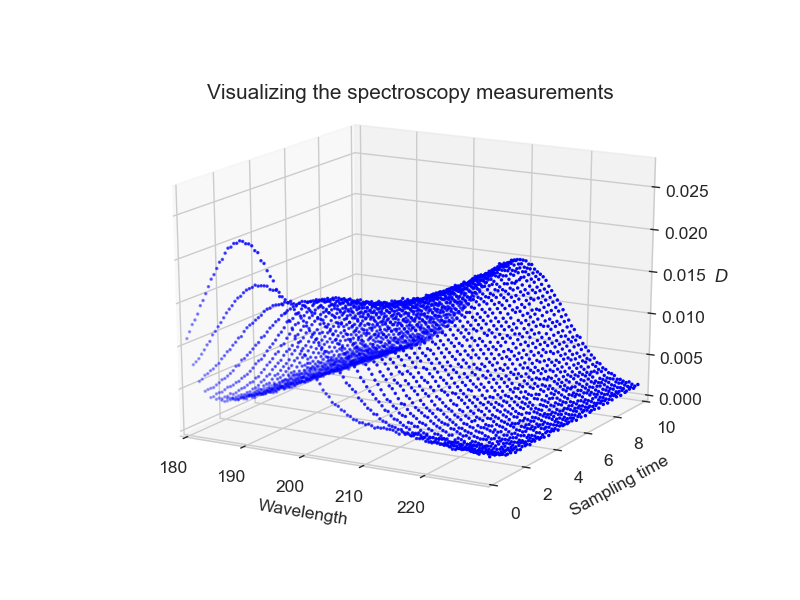

In [33]:
dij_bytime = df.groupby(by=['time'])

%matplotlib notebook
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
sns.set_style('whitegrid')

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

D_max = df['Dij'].max() + df['Dij'].std()
ax.set_xlim([wavelength.min(), wavelength.max()])
ax.set_ylim([time.min(), time.max()])
ax.set_zlim([0, D_max])
ax.set_xlabel('Wavelength')
ax.set_ylabel('Sampling time')
ax.set_zlabel(r'$D$')
ax.set_title(f'Visualizing the spectroscopy measurements')

for i, t in enumerate(time[::15]):
    X, Y = np.meshgrid(wavelength, t)
    Z = dij_bytime.get_group(t)['Dij'].values.reshape(-1, 1)
    ax.scatter(X, Y, Z, '.', s=1, c='b')
    fig.canvas.draw()

fig.show()

<div style="text-align: center;">
    <div style="display: inline-block; text-align: left;">
        <div class="alert alert-block alert-warning">
            The above graph seems to suggest <b> three different peaks. </b> We visualize the progression in 2D:
        </div>
    </div>
</div>

<IPython.core.display.Javascript object>


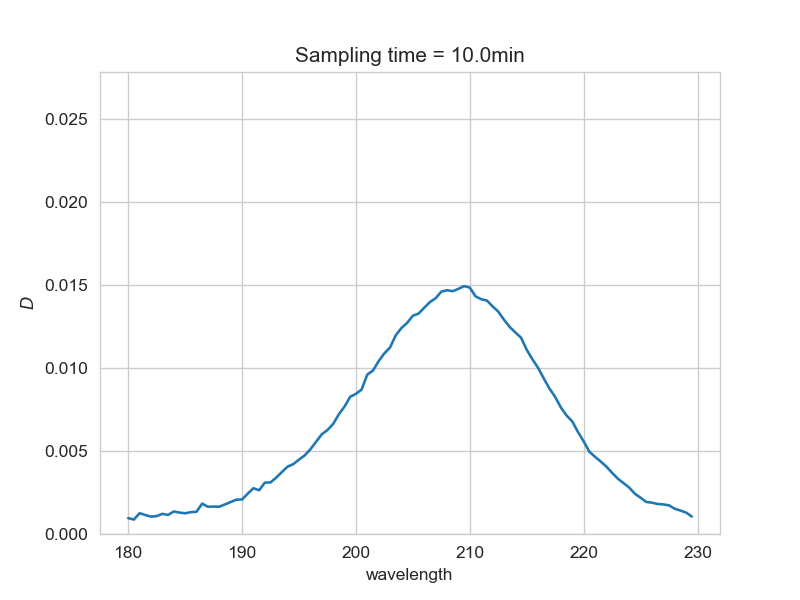

In [34]:
fig, ax = plt.subplots()

D_max = df['Dij'].max() + df['Dij'].std()
ax.set_ylim([0, D_max])
ax.set_ylabel(r'$D$')

for t in time[::10]:
    group = dij_bytime.get_group(t)
    [artist.remove() for artist in ax.lines]
    ax.set_title(f'Sampling time = {t}min')
    group.plot(x='wavelength', y='Dij', ax=ax, legend=False)
    fig.canvas.draw()

fig.show()

## <center> Pure Species Absorbances </center>

In [5]:
s_df = pd.read_csv('S_true.csv', delimiter=',', header=0)
s_df.rename(columns={'Unnamed: 0': 'wavelength'}, inplace=True)
s_df.set_index('wavelength', inplace=True)

components = list(s_df.columns)

s_df

,B,C,A
wavelength,,,
180.0,0.132734,0.099914,1.097788
180.5,0.139873,0.099928,1.169196
181.0,0.148344,0.099965,1.243701
181.5,0.158335,0.100030,1.320820
182.0,0.170045,0.100130,1.399983
...,...,...,...
227.5,0.098096,0.166050,0.365223
228.0,0.099590,0.156045,0.366269
228.5,0.101547,0.147993,0.367688


## <center> Concentration Profiles </center>

<div style="text-align: center;">
    <div style="display: inline-block; text-align: left;">
        <ul>
          <li> For each sampling time, we apply ordinary least squares to solve the Beer's law equation. </li>
          <li> we minimize the least squares objective $\displaystyle \sum_i (D_{ij} - C_{jk} S^\top_{ki})^2 
               \hspace{0.5cm} \forall j$ <br>
               where $i, \, j,$ and $k$ are indices for wavelength, time and species respectively. </li>
        </ul>
    </div>
</div>

In [6]:
from sklearn import linear_model
model = linear_model.LinearRegression()

c = np.empty([ntime, 3])
s = s_df[components].values

from sklearn.model_selection import KFold

n_splits = 5
kf = KFold(n_splits=n_splits, shuffle=True)

for i, t in enumerate(time):
    test_scores = np.zeros(n_splits)
    coefs = []
    for j, (train, test) in enumerate(kf.split(s)): 
        dij = dij_bytime.get_group(t)['Dij'].values
        model.fit(s[train], dij[train])
        test_scores[j] = model.score(s[test], dij[test])
        coefs.append(model.coef_)
#     c[i] = model.coef_
    c[i] = coefs[np.argmax(test_scores)]

pd.DataFrame(c, columns=components)

,B,C,A
0,-0.000028,-1.360988e-05,9.998249e-03
1,0.000299,-6.533837e-07,9.720164e-03
2,0.000578,-2.449683e-05,9.420784e-03
3,0.000884,-7.249579e-06,9.155472e-03
4,0.001127,7.366366e-06,8.882114e-03
...,...,...,...
496,0.001631,8.395914e-03,-1.869994e-05
497,0.001611,8.436657e-03,-7.016871e-07
498,0.001564,8.398933e-03,-3.666127e-06
499,0.001538,8.464964e-03,4.656413e-05


<div style="text-align: center;">
    <div style="display: inline-block; text-align: left;">
        These are the <b> true concentration profiles: </b>
    </div>
</div>

In [7]:
c_true = pd.read_csv('Z_true.csv', delimiter=',', header=0)
c_true.rename(columns={'Unnamed: 0': 'time'}, inplace=True)
c_true

,time,A,B,C
0,0.000000,1.000000e-02,0.000000,0.000000e+00
1,0.015505,9.770112e-03,0.000230,3.582524e-07
2,0.064495,9.077895e-03,0.000916,6.016247e-06
3,0.100000,8.607080e-03,0.001379,1.418143e-05
4,0.115505,8.409214e-03,0.001572,1.875865e-05
...,...,...,...,...
296,9.864495,3.748490e-09,0.001604,8.395541e-03
297,9.900000,3.554078e-09,0.001593,8.406894e-03
298,9.915505,3.472375e-09,0.001588,8.411827e-03
299,9.964495,3.226355e-09,0.001573,8.427311e-03


<div style="text-align: center;">
    <div style="display: inline-block; text-align: left;">
        Comparing the predicted concentrations with the true profiles qualitatively:
    </div>
</div>

<IPython.core.display.Javascript object>


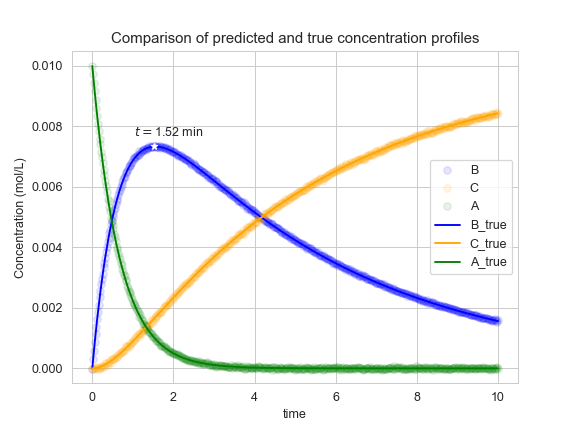

Text(1.02, 0.0077, '$t =$1.52 min')

In [8]:
fig, ax = plt.subplots()

ax.set_ylabel('Concentration (mol/L)')
ax.set_title('Comparison of predicted and true concentration profiles')
ax.set_ylim([0 - 0.0005, 0.01 + 0.0005])
colors = ['blue', 'orange', 'green']
ax.set_prop_cycle(color=colors)

ax.plot(time, c, linestyle='', marker='o', alpha=0.1)
c_true.plot(x='time', y=components, ax=ax)

true_comps = [comp + '_true' for comp in components]
ax.legend(components + true_comps)

# Annotate the peak for species B
bmax = np.argmax(c[:, 0])
ax.plot(time[bmax], c[bmax, 0], color='white', marker='*', markersize=5)
ax.annotate(f"$t =${time[bmax]} min", (time[bmax], c[bmax, 0]), (time[bmax]-0.5, 0.0077), xycoords='data')

<div style="text-align: center;">
    <div style="display: inline-block; text-align: left;">
        We refer back to the absorbance profiles and now we are able to confirm that the three "peaks" in absorbances correspond to the times at which the three species were most abundant in the reaction mixture.
    </div>
</div>

<IPython.core.display.Javascript object>


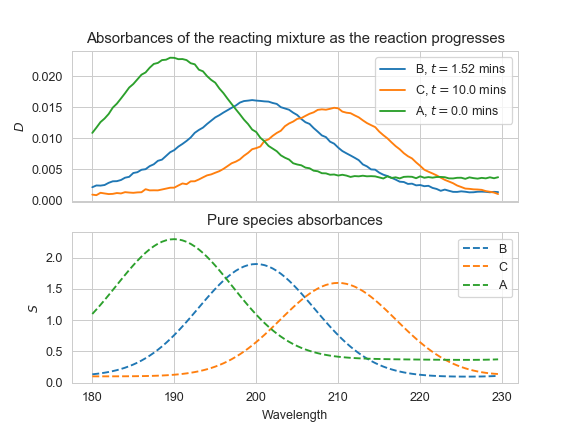

In [9]:
fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True)

colors = ['blue', 'orange', 'green']

ax1.set_ylabel(r'$D$')
ax1.set_title(f'Absorbances of the reacting mixture as the reaction progresses')
legend_text = '{}, $t = ${} mins'

max_idxs = [bmax, -1, 0]  # for B, C and A respectively

for t in time[max_idxs]:
    group = dij_bytime.get_group(t)
    group.plot(x='wavelength', y='Dij', ax=ax1, legend=False)

ax1.legend([legend_text.format(comp, t) for comp, t in zip(components, time[max_idxs])])

ax2.plot(wavelength, s, '--')
ax2.set_title(f'Pure species absorbances')
ax2.set_ylabel(r'$S$')
ax2.set_xlabel('Wavelength')
ax2.legend(components)

## <center> Estimating Kinetic Parameters </center>

<div style="text-align: center;">
    <div style="display: inline-block; text-align: left;">
        From concentration profiles, we generate $dC/dt$ data at each time point.
        $$ \frac{dC}{dt_i} \approx \frac{C_{i+1} - C_i}{t_{i+1} - t_i} $$
    </div>
</div>

In [10]:
dcdt = np.array([np.diff(c[:, i]) / np.diff(time) for i in range(len(components))]).T
print(f'c.shape: {c.shape}, dcdt.shape: {dcdt.shape}')

c.shape: (501, 3), dcdt.shape: (500, 3)


<div style="text-align: center;">
    <div style="display: inline-block; text-align: left;">
        <ul>
            <li> The last step is to fit a linear model to estimate rate constants </li> 
            <li> We use the equation: $\frac{dc_B}{dt} = k_1 c_A - k_2 c_B$ </li> 
            <li> We apply k-fold cross validation by shuffling the data and finally we
                select the model with the best test score. We obtain the following results. </li>
        <ul>
    </div>
</div>

In [18]:
from sklearn.model_selection import KFold

n_splits = 5
kf = KFold(n_splits=n_splits, shuffle=True)

# skip the last row, since dcdt is not defined, columns [2, 0] correspond to species A and B respectively.
X = c[:-1, [2, 0]]
test_scores = np.zeros(n_splits)
coefs = []

for i, (train, test) in enumerate(kf.split(X)):
    model.fit(X[train], dcdt[train, 0])
    test_scores[i] = model.score(X[test], dcdt[test, 0])
    coefs.append(model.coef_)

# choose the model with the best test score
best_score = np.argmax(test_scores)
k = coefs[best_score]
k[1] *= -1  # sign in front of k2 is negative.
print(r'The kinetic rate constants are: k1 = {:.2f} and k2 = {:.2f} per min.'.format(*k))

The kinetic rate constants are: k1 = 1.47 and k2 = 0.20 per min.


<div style="text-align: center;">
    <div style="display: inline-block; text-align: left;">
        We compare these values with the true rate constants.
    </div>
</div>

In [19]:
k_true = np.array([1.50, 0.2])
error = (k - k_true) / k_true * 100
print(r'The precentage error in the estimated rate constants is k1: {:.2f}% and k2: {:.2f}%.'.format(*error))

The precentage error in the estimated rate constants is k1: -2.31% and k2: 0.86%.


## <center> Discussion </center>

<div style="text-align: center;">
    <div style="display: inline-block; text-align: left;">
        <ul>
          <li> In summary, we demonstrated a systematic way of estimating kinetic parameters from spectroscopic data. </li>
          <li> We used ordinary least squares to estimate the parameters using a linear model and
               applied cross-validation to avoid overfitting </li>
          <li> This procedure can be easily extended to </li>
          <ul>
              <li> nonlinear reaction mechanisms </li>
              <li> estimate concentration profiles, kinetic constants and unknown absorbances <b> simultaneously </b> </li>
              <li> incorporate more rigorous regression and machine learning techniques. </li>
          </ul>
        </ul>
        <div class="alert alert-block alert-warning">
            It provides me with a <b> systematic framework </b> I will use in the next few months and
            sets the stage for building simulation models.
        </div>
    </div>
</div>